## 环境配置
在华为云ModelArts平台上运行：https://developer.huaweicloud.com/develop/aigallery/notebook/detail?id=c44ead81-dbff-40f1-a430-d83fe1066291
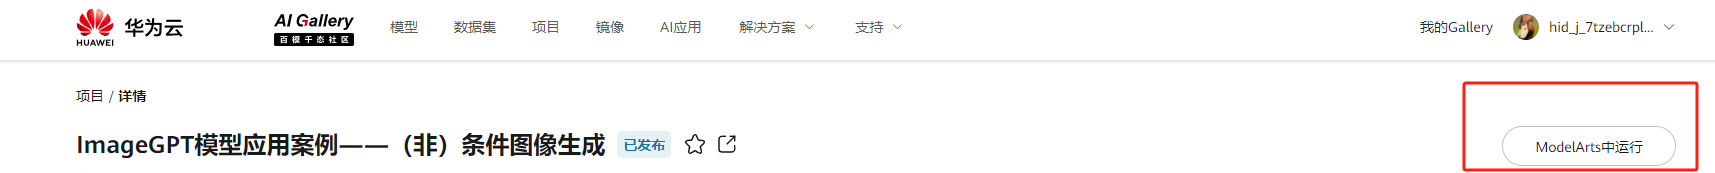

<b>第一步：设置python版本为3.9.0

In [1]:
%%capture captured_output
!/home/ma-user/anaconda3/bin/conda create -n python-3.9.0 python=3.9.0 -y --override-channels --channel https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
!/home/ma-user/anaconda3/envs/python-3.9.0/bin/pip install ipykernel

In [2]:
import json
import os

data = {
   "display_name": "python-3.9.0",
   "env": {
      "PATH": "/home/ma-user/anaconda3/envs/python-3.9.0/bin:/home/ma-user/anaconda3/envs/python-3.7.10/bin:/modelarts/authoring/notebook-conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ma-user/modelarts/ma-cli/bin:/home/ma-user/modelarts/ma-cli/bin"
   },
   "language": "python",
   "argv": [
      "/home/ma-user/anaconda3/envs/python-3.9.0/bin/python",
      "-m",
      "ipykernel",
      "-f",
      "{connection_file}"
   ]
}

if not os.path.exists("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/"):
    os.mkdir("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/")

with open('/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/kernel.json', 'w') as f:
    json.dump(data, f, indent=4)

#### 注：以上代码运行完成后，需要重新设置kernel为python-3.9.0

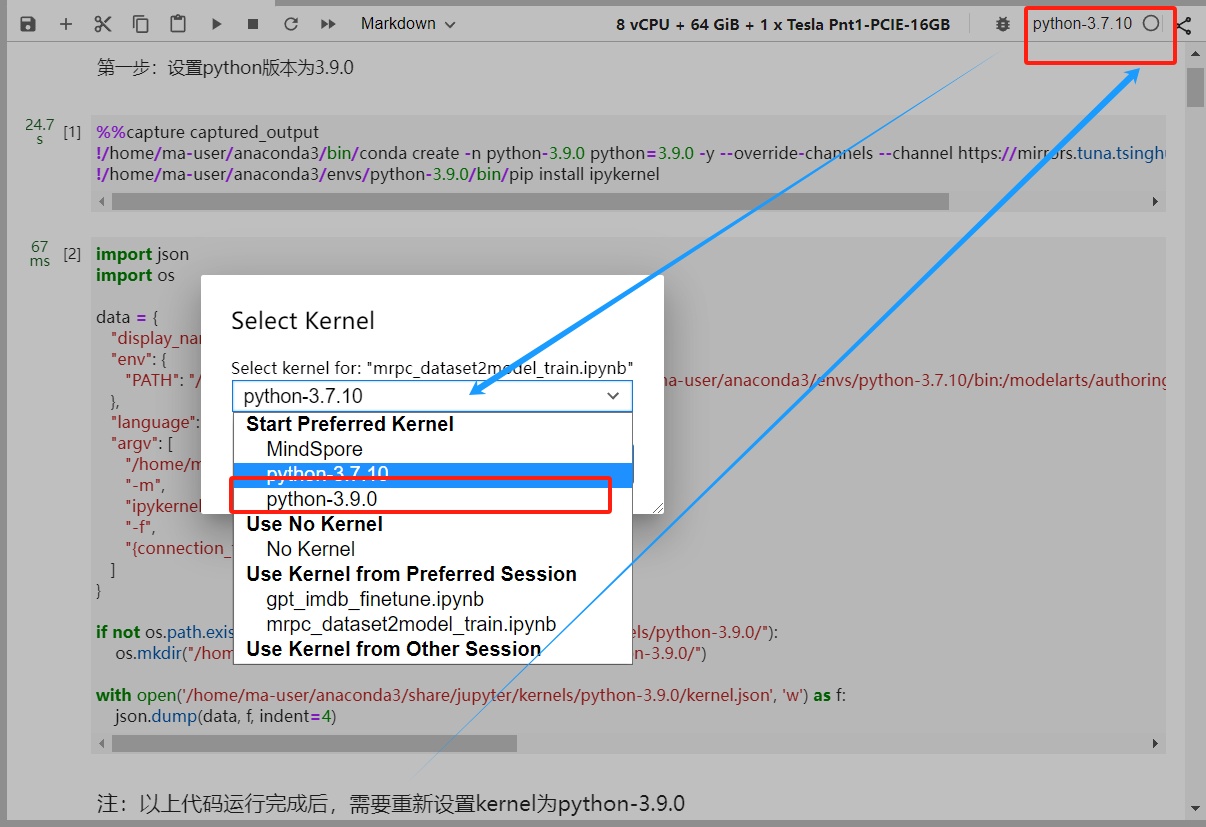

第二步：安装MindSpore框架和MindNLP套件
<pre>
   mindspore安装目前最新的两个版本2.2.14和2.3.1都可以
   但注意 <a href="https://www.mindspore.cn/install">官网的安装文档</a> 的<b>硬件平台</b>要求，如下图。
   目前2.3.1的mindspore仅支持Ascend和CPU（CPU是默认的基础硬件平台），当安装2.3.1的版本时mindspore会检查编译当前环境是否处于Ascend硬件资源下，若没有Ascend可用，后续就只能使用基础的CPU资源，对于参数较多的模型，此时模型推理速度会很慢；
   
   此案例使用GPU资源即可满足模型的推理要求，所以推荐安装mindspore2.2.14
</pre>

[mindspore快速安装](https://www.mindspore.cn/install/)
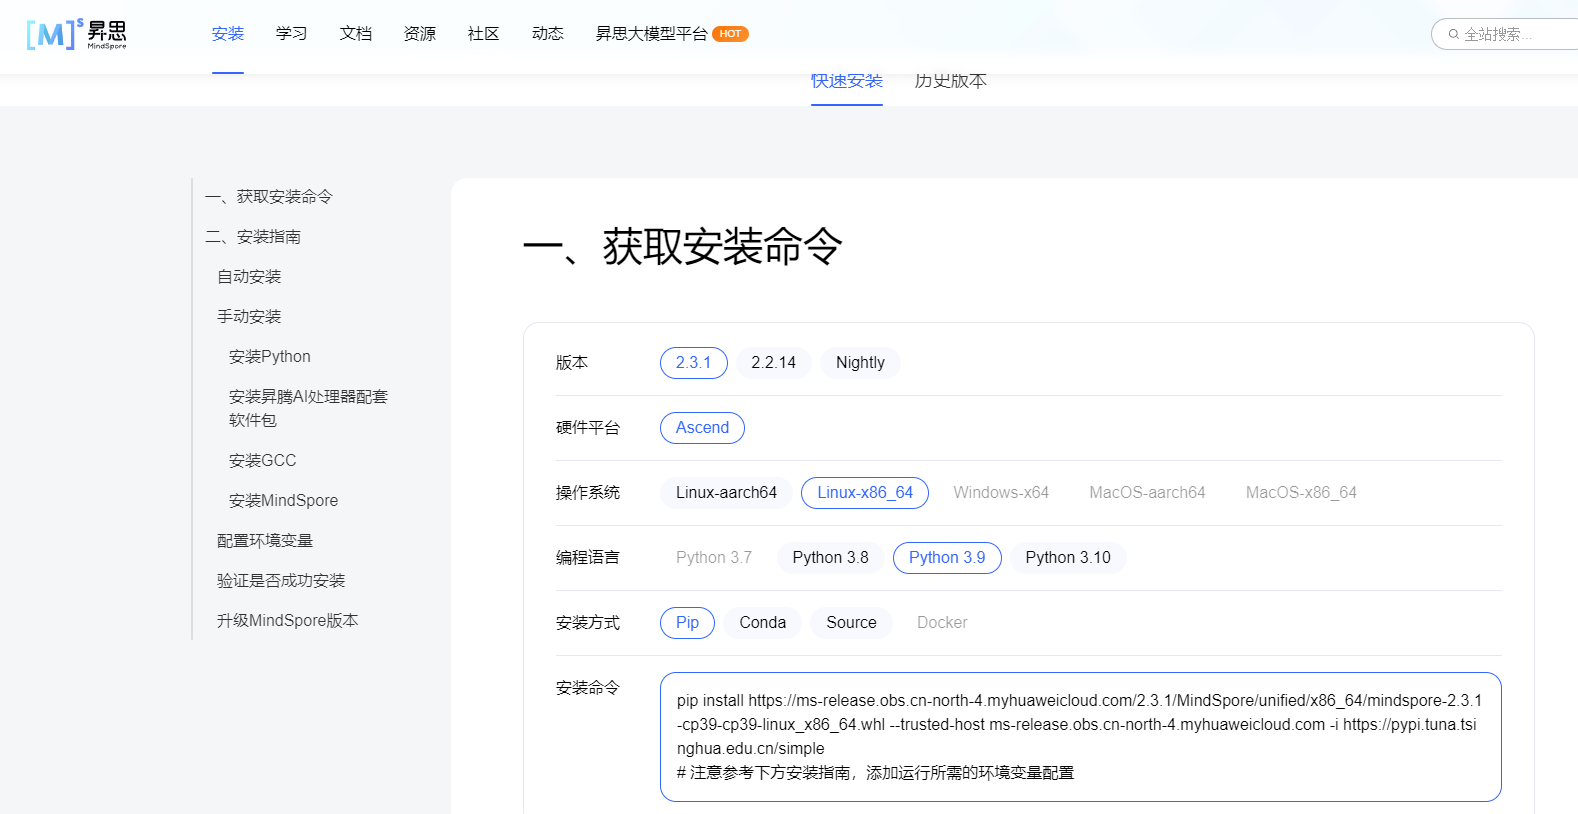

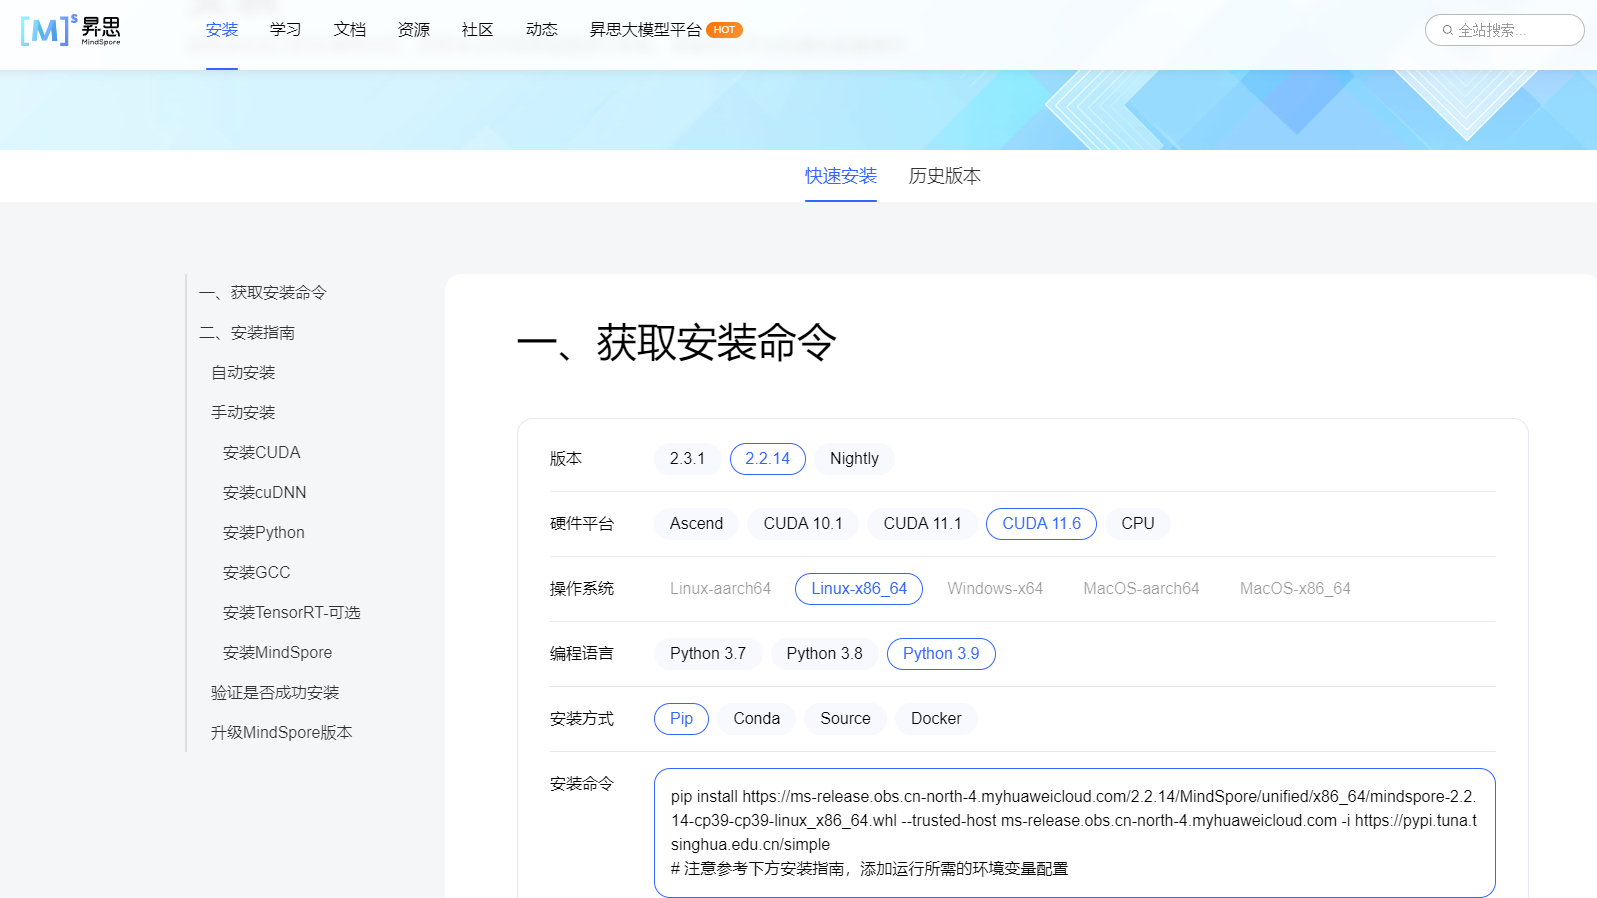

In [1]:
%%capture captured_output

!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.2.14/MindSpore/unified/x86_64/mindspore-2.2.14-cp39-cp39-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

#!pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.3.1/MindSpore/unified/x86_64/mindspore-2.3.1-cp39-cp39-linux_x86_64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
%%capture captured_output

!pip install https://repo.mindspore.cn/mindspore-lab/mindnlp/newest/any/mindnlp-0.4.0-py3-none-any.whl
# 源码安装最新的 mindnlp
# !pip install git+https://github.com/mindspore-lab/mindnlp.git

In [55]:
!pip show mindspore

Name: mindspore



Version: 2.2.14



Summary: MindSpore is a new open source deep learning training/inference framework that could be used for mobile, edge and cloud scenarios.



Home-page: https://www.mindspore.cn



Author: The MindSpore Authors



Author-email: contact@mindspore.cn



License: Apache 2.0



Location: /home/ma-user/anaconda3/envs/python-3.9.0/lib/python3.9/site-packages



Requires: asttokens, astunparse, numpy, packaging, pillow, protobuf, psutil, scipy



Required-by: mindnlp


In [7]:
!pip show mindnlp

Name: mindnlp



Version: 0.4.0



Summary: An open source natural language processing research tool box. Git version: [sha1]:2fb76bf, [branch]: (HEAD, origin/master, origin/HEAD, master)



Home-page: https://github.com/mindlab-ai/mindnlp/tree/master/



Author: MindSpore Team



Author-email: 



License: Apache 2.0



Location: /home/ma-user/anaconda3/envs/python-3.9.0/lib/python3.9/site-packages



Requires: addict, datasets, evaluate, jieba, mindspore, ml-dtypes, pyctcdecode, pytest, regex, requests, safetensors, sentencepiece, tokenizers, tqdm



Required-by: 


In [5]:
%%capture captured_output

# 需要画图，下载相关工具包
!pip install matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple

In [2]:
# 需要 GPU 或Ascend 资源下运行案例代码，不然运行速度很慢且可能看不到生成效果
import mindspore
mindspore.context.get_context('device_target')

'GPU'

## 加载模型和图像处理器

mindnlp官网相关参考：https://mindnlp.cqu.ai/zh/api/transformers/models/imagegpt/

In [5]:
from mindnlp.transformers import ImageGPTImageProcessor, ImageGPTForCausalImageModeling
import numpy as np
import mindspore
from mindspore import ops

/home/ma-user/anaconda3/envs/python-3.9.0/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



  from .autonotebook import tqdm as notebook_tqdm



Building prefix dict from the default dictionary ...



Dumping model to file cache /tmp/jieba.cache



Loading model cost 0.799 seconds.



Prefix dict has been built successfully.


In [6]:
model_size = 'medium'   # 或者small，根据当前开发资源自行选择，模型越大需要的内存和算力越大
model_hugging_face = f'openai/imagegpt-{model_size}'

image_processor = ImageGPTImageProcessor.from_pretrained(model_hugging_face)
model = ImageGPTForCausalImageModeling.from_pretrained(model_hugging_face)

46.5kB [00:00, 109kB/s]



100%|██████████| 511/511 [00:00<00:00, 2.00MB/s]



100%|██████████| 1.73G/1.73G [02:00<00:00, 15.4MB/s] 


imageGPT模型的预训练模型是经过大量的无标签图像数据集通过无监督训练得到的，原始图像（如3通道的彩色图）在输入imageGPT模型前，需要经过不同与以往作为卷积神经网络模型的输入时的处理

ImageGPT原论文[ImageGPT paper](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)的3.2中提到了该模型的输入的处理与转换

<pre>
    在使用ImageGPT这种采用密集注意力机制的 Transformer 编码、解码器时，运行内存需求会随着上下文context（一个序列）的长度的增加而呈二次方增长，因此必须采取减少context长度的技术。
    
    具体地，如果直接训练一个序列长度为224 x 224 × 3的Transformer，其注意力计算量将非常巨大，以至于模型无法适应。ImageGPT的研究者提出的方法：
    
    1.首先将图像（默认是3通道的彩色图像）降低到一个较低的分辨率，称为输入分辨率(IR)，如 IR=32 x32 ×3 ；（也可以不降低，直接跳到step3，此时一般用来训练更大参数量的imagegpt模型）
    2. 降低分辨率后仍然计算量很大，但不能继续降低分辨率，这会损失大量的信息以至于效果急剧降低。受早期彩色显示调色板的启发，通过使用k-means聚类方法创建一个包含512种颜色的9位彩色调色板，这样得到的输入序列长度比标准RGB调色板短三倍，同时尽可能地保存编码颜色信息。
    3.使用调色板后，每个像素可以用一个索引来表示，而不是3个通道的值，所以可以将原始地IR降低3倍。注：每个像素只需要9位（bits）来表示（因为 2^9 = 512），而不是原始的24位（3x8位，RGB每个通道8位）通过这种方法得到的上下文长度称为模型分辨率(MR)，如MR = 32 x 32，这样最后context的序列长度为32 x 32 = 1024.
    
     图像处理器(ImageGPTImageProcessor)规范化了上述方法，可用于将图像调整到较小的分辨率（如32x32或64x64），对其进行归一化，最后对其进行颜色量化，以获得“像素值”序列（颜色簇）。
</pre>

可通过help(image_processor)打印详细的说明文档，了解其内部是如何工作的

In [5]:
help(image_processor)

Help on ImageGPTImageProcessor in module mindnlp.transformers.models.imagegpt.image_processing_imagegpt object:







class ImageGPTImageProcessor(mindnlp.transformers.image_processing_utils.BaseImageProcessor)



 |  ImageGPTImageProcessor(clusters: Union[List[List[int]], numpy.ndarray, NoneType] = None, do_resize: bool = True, size: Dict[str, int] = None, resample: PIL.Image.Resampling = <Resampling.BILINEAR: 2>, do_normalize: bool = True, do_color_quantize: bool = True, **kwargs) -> None



 |  



 |  Constructs a ImageGPT image processor. This image processor can be used to resize images to a smaller resolution



 |  (such as 32x32 or 64x64), normalize them and finally color quantize them to obtain sequences of "pixel values"



 |  (color clusters).



 |  



 |  Args:



 |      clusters (`np.ndarray` or `List[List[int]]`, *optional*):



 |          The color clusters to use, of shape `(n_clusters, 3)` when color quantizing. Can be overriden by `clusters`



 |          in `

In [25]:
print(image_processor)
print(image_processor.clusters.shape)

ImageGPTImageProcessor {



  "_valid_processor_keys": [



    "images",



    "do_resize",



    "size",



    "resample",



    "do_normalize",



    "do_color_quantize",



    "clusters",



    "return_tensors",



    "data_format",



    "input_data_format"



  ],



  "clusters": [



    [



      0.8866443634033203,



      0.6618829369544983,



      0.3891746401786804



    ],



    [



      -0.6042559146881104,



      -0.02295008860528469,



      0.5423797369003296



    ],



    [



      0.12942790985107422,



      0.03570118546485901,



      -0.3643915355205536



    ],



    [



      -0.3553103804588318,



      -0.15857496857643127,



      -0.664303183555603



    ],



    [



      0.7844981551170349,



      -0.2559399902820587,



      -0.7189618945121765



    ],



    [



      0.1935412883758545,



      0.23239648342132568,



      0.08234082162380219



    ],



    [



      -0.9012048840522766,



      -0.7926875

根据以上信息，可简要概括一下当前加载的ImageGPTImageProcessor预训练处理器的基本信息：
<pre>
1. **颜色量化**: 启用 (do_color_quantize=True)
2. **归一化**: 启用 (do_normalize=True)
3. **调整尺寸**: 启用 (do_resize=True)
4. **重采样方法**: PIL.Image.Resampling.BILINEAR (双线性插值)
5. **图像尺寸**: 高度32像素，宽度32像素 (size={"height": 32, "width": 32})
6. **颜色聚类**: 包含多组RGB值，用于颜色量化

该处理器能够对图像进行大小调整、归一化和颜色量化处理，以适配ImageGPT模型的输入要求。


这里的image_processor.clusters是一个核心处理参数
    `clusters`具有形状`(n_clusters, 3)`，其中`n_clusters`是聚类的数量（这里是512），而3代表RGB颜色空间的三个通道。这个参数定义了颜色量化过程中使用的颜色簇。
    在实际的颜色量化操作中，`clusters`通过将图像中的每个像素颜色与预定义的聚类中心颜色进行比较，并将像素颜色替换为最近的聚类中心颜色，从而实现颜色的量化（也即颜色聚类），减少了图像中使用的颜色数量，使得图像数据更加紧凑，同时尝试保留图像的主要视觉特征。
    注意：这里的颜色量化（颜色聚簇）需要结合归一化操作，即先对像素进行归一化，再进行颜色量化
</pre>


<b>举例使用ImageGPTImageProcessor处理一张图片

In [7]:
import matplotlib.pyplot as plt

def show_image(image, dpi=100):
    f, ax = plt.subplots(1, 1, dpi=dpi)
    ax.axis("off")
    ax.imshow(image)

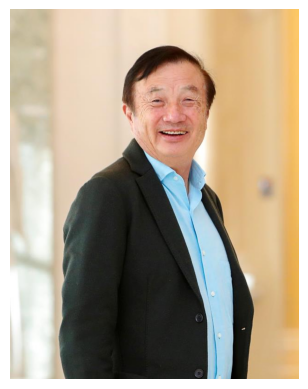

In [8]:
from PIL import Image
import requests
url = "https://p.statickksmg.com/image/2021/09/14/111535a5c34bc095668dc9faf083e895.jpg"
image = Image.open(requests.get(url, stream=True).raw)
show_image(image)

In [9]:
inputs = image_processor(images=image, return_tensors="ms")

# 分别获得原始图片数据img和作为模型输入的token序列
img = np.array(image)
samples = inputs['input_ids']

img.shape, samples.shape

((800, 624, 3), (1, 1024))

clusters: (512, 3) , height: 32 , width: 32


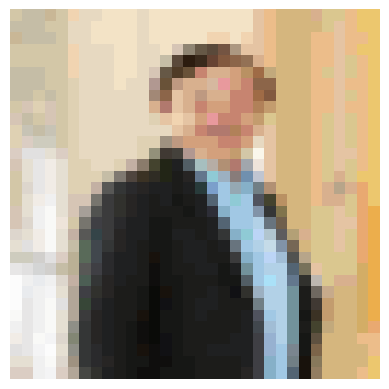

In [10]:
# 显示降低分辨率且进行颜色聚簇后的图像
import matplotlib.pyplot as plt

def get_imgs_from_samples(samples, image_process: ImageGPTImageProcessor):
    """
    samples是经过ImageGPTImageProcessor的对象处理过的输入token序列，或者imageGPT模型的generate方法生成的预测序列
    samples：（n, seq_len），其中n为样本数量，seq_len为序列长度（也即一个样本所含的token的数量）
    """
    clusters = image_processor.clusters
    height = image_processor.size["height"]
    width = image_processor.size["width"]
    print('clusters:', clusters.shape, ', height:', height, ', width:', width)
    
    # 将颜色聚簇成的tokens转换成像素值，并调整序列为图像形状
    samples_img = [
                np.reshape(np.rint(127.5 * (clusters[sample] + 1.0)), [height, width, 3]).astype(np.uint8) for sample in samples.copy().asnumpy()
                ] 
    return samples_img


samples_img = get_imgs_from_samples(samples, image_processor)

show_image(samples_img[0])

## 非条件图像生成的例子
<pre>
    向模型提供序列的开始（SOS）token，即vocab_size -1 ，并让模型使用`generate（）`方法生成 32 x 32 = 1024的输出序列，序列由“像素值”token组成，每个像素值是512个可能的颜色簇之一。
    
    ImageGPTForCausalImageModeling的generate方法ImageGPTForCausalImageModeling的generate方法即这里的model.generate(input_ids=inputs_ids, max_length=w*h + 1, temperature=1.0, do_sample=True, top_k=40)model.generate(input_ids=inputs_ids, max_length=w*h + 1, temperature=1.0, do_sample=True, top_k=40)的参数含义参考：
    inputs: 输入序列，用作生成的提示或模型编码器的输入，可以代表 input_ids、input_values、input_features或pixel_values。
    
    max_length: 生成序列的最大长度。通常设置为宽度乘以高度再加1（w*h + 1，加1是以为生成的预测序列的第一个token_id是开始标记token），以适应图像的尺寸或文本的预期长度。

    temperature: 控制生成过程的随机性。值越高，生成的序列越随机。通常设置为1.0。
    
    do_sample: 是否随机采样。如果设置为True，则会从概率分布中随机选择token，而不是总是选择概率最高的token。
    
    top_k: 每次采样时，从概率分布中选择的token数量。如果设置为40，则在每次生成步骤中，将从概率最高的40个token中选择一个。
</pre>

In [33]:
from mindspore import ops

# unconditional generation of batch_size images
batch_size = 8
token_tested = model.config.vocab_size - 1
sequences = ops.full( (batch_size, 1), token_tested )  # initialize with token_tested token

print('token_tested: ', token_tested)
print('sequences.shape: ',sequences.shape)

token_tested:  512



sequences.shape:  (8, 1)


In [34]:
output = model.generate(input_ids=sequences, max_length=model.config.n_positions + 1, temperature=1.0, do_sample=True, top_k=40)
samples = output[:,1:].asnumpy()

samples.shape

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


(8, 1024)

clusters: (512, 3) , height: 32 , width: 32


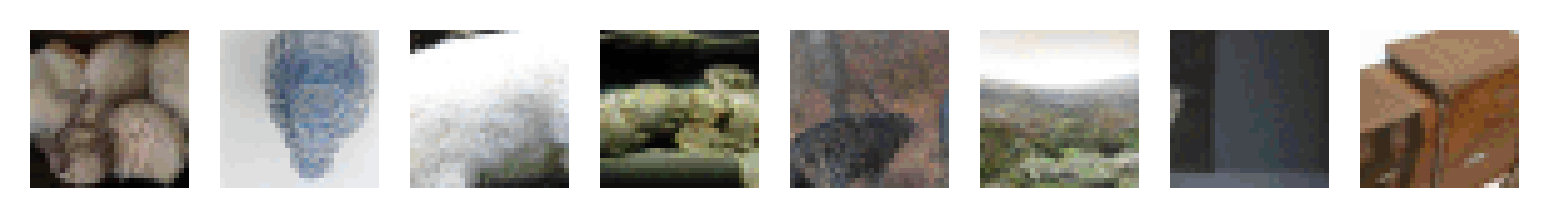

In [35]:
import matplotlib.pyplot as plt

# visualize samples with Image-GPT color palette.
samples_img = get_imgs_from_samples(output[:,1:], image_processor)

f, axes = plt.subplots(1, batch_size, dpi=300)

for img, ax in zip(samples_img, axes):  # doctest: +IGNORE_RESULT
    ax.axis("off")
    ax.imshow(img)

## 条件图像生成的例子
<pre>
    1.将一张原图经过image_preocess处理（降低分辨率、颜色聚簇）成token序列 sequence，可作为模型的输入；
    2.取上述sequence 的前1/2（或者1/4等）作为模型的条件输入序列 sequence_condi，相当于取降低分辨率之后的图像（模型分辨率MR）的前半张图像
    3.将模型的输入开始标记(SOS token)和 sequence_condi 拼接为input_id，作为最后模型的输入；
    4.最后调用imageGPT模型的generate方法，期望根据半张图的序列 sequence_condi 预测生成整张图
    
   注：上述操作可批量操作，即通过批量复制原图生成的sequence，一次预测生成多张不同的图(对同一张残缺图的不同预测生成，这在实际应用中可提供完整图修复的多种参考)
</pre>

原图


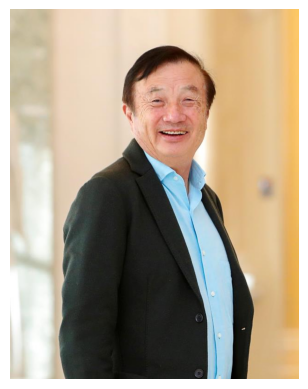

In [36]:
print('原图')
show_image(image)

In [14]:
def get_inputs_ids(image, batch_size=8, n_px_crop=16):
    """
    对原始输入图像image通过图像处理器处理成模型的输入序列
    batch_size 表示最后预测生成的图像数量
    n_px_crop 指定取模型分辨率下的图像的前 n_px_crop 行像素作为条件输入 
    """
    sequences = image_processor([image for _ in range(batch_size)], return_tensors="ms")
    
    clusters = image_processor.clusters
    size = image_processor.size
    h,w = size['height'],size['width']

    sequences = sequences.input_ids.asnumpy()
    print(sequences.shape)
    
    # get conditioning tokens
    sequences_condi = sequences[:,:n_px_crop * w] 
    print(sequences_condi.shape)
    
    # 将模型配置中的词汇表大小与 sequences_condi 进行拼接，得到 context
    tokens_sos = np.full((batch_size, 1), model.config.vocab_size - 1)
    inputs_ids = np.concatenate((tokens_sos, sequences_condi), axis=1)
    inputs_ids = mindspore.Tensor(inputs_ids)
    
    print(inputs_ids.shape)
    
    return inputs_ids, sequences, sequences_condi

batch_size = 8
n_px_crop = 16

image_processor.do_color_quantize = True
image_processor.do_normalize = True
image_processor.do_resize = True

inputs_ids, sequences, sequences_condi = get_inputs_ids(image, batch_size, n_px_crop)

(8, 1024)



(8, 512)



(8, 513)


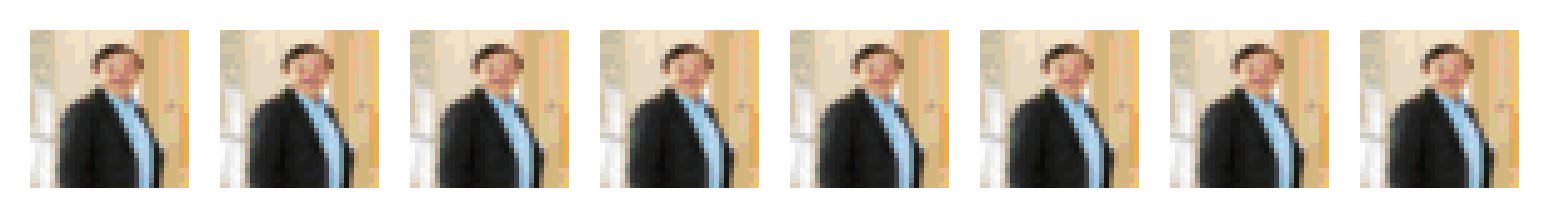

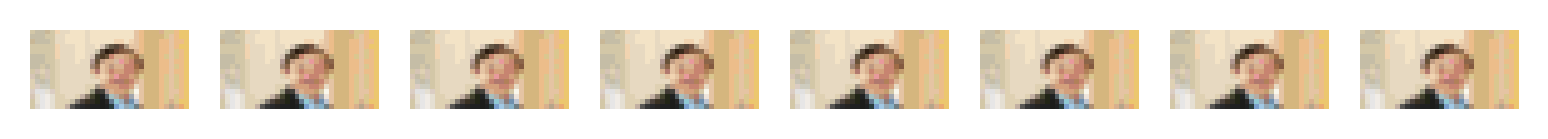

In [40]:
# visualize samples and crops with Image-GPT color palette. Should look similar to original resized images
size = image_processor.size
h,w = size['height'],size['width']
clusters = image_processor.clusters

samples_img = [np.reshape(np.rint(127.5 * (clusters[sample] + 1.0)), [w, h, 3]).astype(np.uint8) for sample in sequences]  # convert color clusters back to pixels
primers_img = [np.reshape(np.rint(127.5 * (clusters[sample] + 1.0)), [n_px_crop, h, 3]).astype(np.uint8) for sample in sequences_condi]  # convert color clusters back to pixels

f, axes = plt.subplots(1, batch_size, dpi=300)
for img,ax in zip(samples_img, axes):
    ax.axis('off')
    ax.imshow(img)

f, axes2 = plt.subplots(1, batch_size, dpi=300)
for img,ax in zip(primers_img, axes2):
    ax.axis('off')
    ax.imshow(img)

In [41]:
output = model.generate(input_ids=inputs_ids, max_length=w*h + 1, temperature=1.0, do_sample=True, top_k=40)

In [42]:
output.shape

(8, 1025)

In [43]:
output[0][0], output[2][0], output[7][0]

(Tensor(shape=[], dtype=Int64, value= 512),
 Tensor(shape=[], dtype=Int64, value= 512),
 Tensor(shape=[], dtype=Int64, value= 512))

clusters: (512, 3) , height: 32 , width: 32


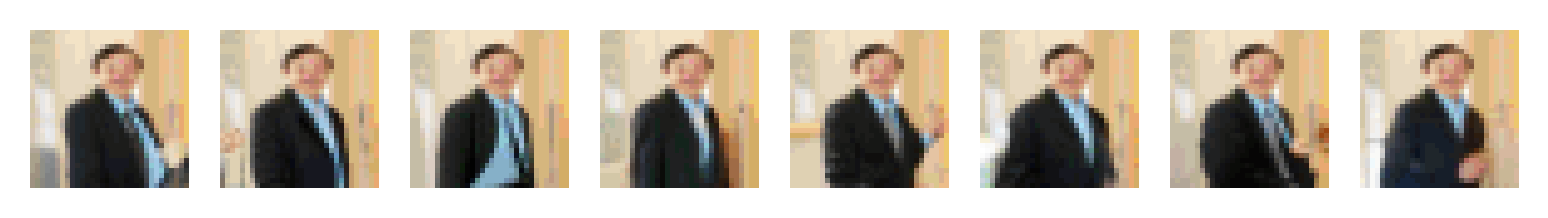

In [44]:
# visualize samples with Image-GPT color palette. 
# 模型的预测输出序列的第一个token是开始标记，获取预测生成的低分辨率图像前需要去掉该token
samples_img = get_imgs_from_samples(output[:,1:], image_processor)

f, axes = plt.subplots(1, batch_size, dpi=300)

for img,ax in zip(samples_img, axes):
    ax.axis('off')
    ax.imshow(img)

<b>可自行找一张其他类型的图片看看预测生成效果

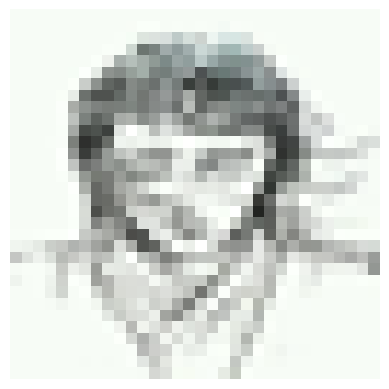

In [11]:
url = 'https://www.puchedu.cn/uploads/0/253/1457785469/151526013.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

size = image_processor.size
h,w = size['height'],size['width']
show_image(image.resize((w,h)))

In [15]:
inputs_ids, sequences, sequences_condi = get_inputs_ids(image, batch_size=4, n_px_crop=20)   # 这里取原图的前 20/32 = 5/8部分作为条件输入（残缺的低分辨率图像）

output1 = model.generate(input_ids=inputs_ids, max_length=w*h + 1, temperature=1.0, do_sample=True, top_k=40)
samples_img = get_imgs_from_samples(output1[:,1:], image_processor)

(4, 1024)



(4, 640)



(4, 641)


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


clusters: (512, 3) , height: 32 , width: 32


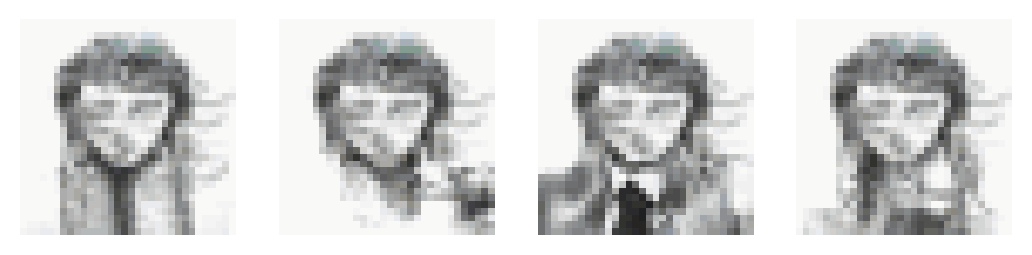

In [16]:
f, axes = plt.subplots(1, 4, dpi=200)

for img,ax in zip(samples_img, axes):
    ax.axis('off')
    ax.imshow(img)